In [3]:
#This is the notebook I will use to create my logistic regression models

In [4]:
import numpy as np
import pandas as pd
%pylab inline
import csv
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


In [5]:
mdiag_cols = ['CASEID','AMHTXRC3','AMHSVTYP','AMHTXND2','SPDYR','SPDMON','K6SCYR','K6SCMON','K6SCMAX','WHODASC2',
              'SMIPP_U','AMDELT','AMDEYR','ATXMDEYR','ARXMDEYR','IRINSUR4','GOVTPROG',
              'INCOME','POVERTY2','IRSEX','IRMARIT','HEALTH2','CATAG3','NEWRACE2','EDUCCAT2']
Mental_Diagnostics = pd.read_csv('C:/Users/Cody/Downloads/NSDUH/2014/NSDUH-2014-DS0001-data/NSDUH-2014-DS0001-data-excel.tsv',usecols=mdiag_cols, sep='\t', index_col=0)

In [6]:
#change to N/A for missing data
Mental_Diagnostics.AMHTXRC3.astype('int')
Mental_Diagnostics.AMHTXRC3.replace(int(2),int(0),inplace=True)#received any mental health trt past year
Mental_Diagnostics.replace(-9, np.nan, inplace=True)
Mental_Diagnostics.IRMARIT.replace(99,np.nan,inplace=True)#1-married,2-widowed,3-seperated/div,4-never married
#change vars coded 1:yes, 2:no --> 1:yes, 0:no 
Mental_Diagnostics.AMHTXND2.replace(2,0,inplace=True)#perceived need for mental health treatment in past year
Mental_Diagnostics.AMDELT.replace(2,0,inplace=True)#lifetime major depressive episode
Mental_Diagnostics.AMDEYR.replace(2,0,inplace=True)#past year major depressive episode
Mental_Diagnostics.GOVTPROG.replace(2,0,inplace=True)#participate in government assistance programs
Mental_Diagnostics.IRINSUR4.replace(2,0,inplace=True)#1-has insurance, 0-no insurance
Mental_Diagnostics.IRSEX.replace(2,0,inplace=True)#1-male, 0-female

In [7]:
mh_sample = Mental_Diagnostics[Mental_Diagnostics.SPDYR==1]
#SPDYR = 1(subsample of 5696 adults) experienced psychological distress this past year
#my logistic regression will apply to the population of adults who experienced severe psychological distress in the past year in the U.S.

0.0    0.554675
1.0    0.445325
Name: AMHTXRC3, dtype: float64

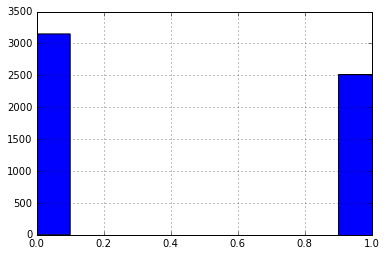

In [581]:
mh_sample['AMHTXRC3'].hist()
mh_sample['AMHTXRC3'].value_counts()/mh_sample['AMHTXRC3'].count()

In [9]:
dummy_ages = pd.get_dummies(mh_sample['CATAG3'],prefix='age') # 2:18-25, 3:26-34, 4:35-49, 5:50+
dummy_marriage = pd.get_dummies(mh_sample['IRMARIT'],prefix='marriage') # 1-married, 2-widowed, 3-sep/div, 4-unmarried
dummy_race = pd.get_dummies(mh_sample['NEWRACE2'],prefix='race') # 1-White, 2-Black, 3-Native American, 4-Pacific Islander, 5-Asian, 6-Mixed, 7-Hispanic
dummy_health = pd.get_dummies(mh_sample['HEALTH2'],prefix='health') # overall health(1-excellent, 2-very good, 3-good, 4-fair/poor)
dummy_education = pd.get_dummies(mh_sample['EDUCCAT2'],prefix='education') #1-less than high school, 2-high school grad, 3-some college, 4-college graduate

In [10]:
#create a table with just the columns I want to use for logistic regression
cols_to_keep = ['AMHTXRC3','AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','IRINSUR4']
data = mh_sample[cols_to_keep].copy()
data = data.join(dummy_ages.ix[:,'age_2':])
data = data.join(dummy_race.ix[:,'race_1':])
data = data.join(dummy_health.ix[:,'health_1':])
#data = data.join(dummy_education.ix[:,'education_2':])
#data = data.join(dummy_marriage.ix[:,'marriage_2':])
data['intercept'] = 1
#finally realized that it was the n/a values in the data messing up my logistic regression, so I dropped the rows with N/A values
data = data[pd.notnull(data['AMHTXRC3'])]
data = data[pd.notnull(data['AMHTXND2'])]
data = data[pd.notnull(data['AMDELT'])]
data.describe()

,AMHTXRC3,AMHTXND2,WHODASC2,SMIPP_U,AMDELT,IRSEX,IRINSUR4,age_2,age_3,age_4,...,race_3,race_4,race_5,race_6,race_7,health_1.0,health_2.0,health_3.0,health_4.0,intercept
count,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,...,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.0
mean,0.445332,0.294462,11.972666,0.227417,0.544551,0.349840,0.826234,0.460596,0.212460,0.212638,...,0.016862,0.005325,0.036209,0.044373,0.148740,0.133475,0.337771,0.308129,0.220447,1.0
std,0.497047,0.455841,6.245606,0.260468,0.498055,0.476962,0.378942,0.498489,0.409085,0.409210,...,0.128765,0.072783,0.186826,0.205942,0.355863,0.340118,0.472992,0.461761,0.414585,0.0
min,0.000000,0.000000,0.000000,0.004284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,8.000000,0.029295,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,12.000000,0.106492,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,1.000000,1.000000,16.000000,0.355731,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0
max,1.000000,1.000000,24.000000,0.929121,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [11]:
#now I have my table with all of the potential predictor variables
#I am looking into a method that will select the K best predictors for my response variable AMHTXRC3

In [12]:
train_cols = data.columns[1:]
#train_cols = data['AMHTXRC3','AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_2','race_1','health_2.0']


In [13]:
logit = sm.Logit(data['AMHTXRC3'],data[train_cols])
result=logit.fit()

         Current function value: 0.570453
         Iterations: 35


C:\Users\Cody\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [187]:
#result.summary()
#I tried to fit a model with all of the variables and the variables with the highest p-values in order are:
#education_2, marriage_3, marriage_4, marriage_2, education_3, education_4, K6SCMAX eliminated
#race_3, race_4, race_6, health_2, health_3
#I will use backwards variable selection to reduce the model to something more realistic and useful
#Update: Reduced to 8 variables(including categoricals)


##Update : Repressed results because they include all dummy variables for categoricals

In [15]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%','97.5%','OR']
np.exp(conf)
#the table below shows us the 95% confidence interval for the odds ratios of each predictor
#this is the odds ratio for receiving treatment for those with serious psychological distress in the past year

,2.5%,97.5%,OR
AMHTXND2,1.294729,1.699858,1.483528e+00
WHODASC2,1.045786,1.073605,1.059605e+00
SMIPP_U,1.995533,3.939458,2.803805e+00
AMDELT,1.247412,1.638623,1.429698e+00
IRSEX,0.614719,0.791960,6.977343e-01
IRINSUR4,1.854636,2.600402,2.196087e+00
age_2,0.000000,inf,1.057432e+01
age_3,0.000000,inf,1.739871e+01
age_4,0.000000,inf,2.231524e+01
age_5,0.000000,inf,2.698072e+01


In [19]:
cols_to_keep = ['AMHTXRC3','WHODASC2','AMDELT','IRSEX']
data2 = mh_sample[cols_to_keep].copy()
data2 = data2.join(dummy_ages.ix[:,'age_3':])
data2 = data2.join(dummy_race.ix[:,'race_2':])
data2 = data2.join(dummy_health.ix[:,'health_2':])
data2['intercept'] = 1
data2 = data2[pd.notnull(data2['AMHTXRC3'])]
data2 = data2[pd.notnull(data2['AMDELT'])]

In [20]:
train_cols = data2.columns[1:]

In [21]:
logit = sm.Logit(data2['AMHTXRC3'],data2[train_cols])
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.585997
         Iterations 6


In [22]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               AMHTXRC3   No. Observations:                 5646
Model:                          Logit   Df Residuals:                     5630
Method:                           MLE   Df Model:                           15
Date:                Wed, 17 Aug 2016   Pseudo R-squ.:                  0.1472
Time:                        15:18:11   Log-Likelihood:                -3308.5
converged:                       True   LL-Null:                       -3879.8
                                        LLR p-value:                3.474e-234
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
WHODASC2       0.0856      0.005     15.749      0.000         0.075     0.096
AMDELT         0.5546      0.064      8.668      0.000         0.429     0.680
IRSEX         -0.3835      0.063     -6.073      0.000        -0.507    -0.260
age_3          0.4816      0.077      6.236      0.000         0.330     0.633
age_4          0.7673      0.079      9.716      0.000         0.613     0.922
age_5          0.9876      0.103      9.614      0.000         0.786     1.189
race_2        -0.7433      0.104     -7.125      0.000        -0.948    -0.539
race_3        -0.6614      0.240     -2.759      0.006        -1.131    -0.192
race_4        -1.2086      0.461     -2.621      0.009        -2.113    -0.305
race_5        -1.0788      0.185     -5.841      0.000        -1.441    -0.717
race_6        -0.4105      0.146     -2.810      0.005        -0.697    -0.124
race_7        -0.7462      0.089     -8.370      0.000        -0.921    -0.571
health_2.0     0.3354      0.099      3.382      0.001         0.141     0.530
health_3.0     0.3461      0.101      3.443      0.001         0.149     0.543
health_4.0     0.5796      0.109      5.299      0.000         0.365     0.794
intercept     -1.9307      0.115    -16.852      0.000        -2.155    -1.706
==============================================================================
"""

In [23]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%','97.5%','OR']
np.exp(conf)
#the table below shows us the 95% confidence interval for the odds ratios of each predictor
#this is the odds ratio for receiving treatment for those with serious psychological distress in the past year

,2.5%,97.5%,OR
WHODASC2,1.077792,1.100992,1.089330
AMDELT,1.536030,1.973886,1.741249
IRSEX,0.602143,0.771250,0.681471
age_3,1.391297,1.883183,1.618662
age_4,1.845142,2.514626,2.154029
age_5,2.195182,3.283601,2.684791
race_2,0.387600,0.583417,0.475533
race_3,0.322619,0.825659,0.516114
race_4,0.120930,0.737333,0.298606
race_5,0.236753,0.488316,0.340015


In [24]:
#Logistic Model 1

In [25]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

#I imported the important functions from sklearn to split my data into training and test data,
#initialize a logistic regression model, perform cross-validation, and score the accuracy of the model on the test data.

In [43]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(data[['AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_3','age_4','age_5','race_2','race_3','race_4','race_5','race_6','race_7',
                                                    'health_2.0','health_3.0','health_4.0']].values, 
                                              (data['AMHTXRC3'] == 1).values,random_state=5)

In [44]:
clf = LogisticRegression()
clf.fit(Xlr,ylr)
print (accuracy_score(clf.predict(Xtestlr),ytestlr))

0.693399574166


In [45]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print (score)

0.687810650888


In [29]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
max_score = 0

#your turn
for C in Cs :
    clf = LogisticRegression(C=C)
    score = cv_score(clf, Xlr, ylr)
    
    if score > max_score :
        max_score = score
        bestC = C
        
print("Best C value:",bestC)
print("Average Score using this C:",max_score)

Best C value: 0.1
Average Score using this C: 0.690177514793


In [30]:
clfBest = LogisticRegression(C=bestC)
clfBest.fit(Xlr,ylr)
ypred = clfBest.predict(Xtestlr)
accuracy_score(ypred,ytestlr)

0.69836763662171752

In [31]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print ("Accuracy on training data: %0.2f" % (training_accuracy))
    print ("Accuracy on test data:     %0.2f" % (test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [32]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print ("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [42]:
??LogisticRegression

In [33]:
#Buffer

In [34]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_3','age_4','age_5','race_2','race_3','race_4','race_5','race_6','race_7',
                                                    'health_2.0','health_3.0','health_4.0'], 'AMHTXRC3',1)

BEST PARAMS {'C': 1}
Accuracy on training data: 0.69
Accuracy on test data:     0.71


In [35]:
#Logistic Model 2

In [36]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(data[['AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_2','race_1','race_2','race_7',
                                                    ]].values, 
                                              (data['AMHTXRC3'] == 1).values,random_state=5)

In [37]:
clf = LogisticRegression()
clf.fit(Xlr,ylr)
print (accuracy_score(clf.predict(Xtestlr),ytestlr))

0.694109297374


In [38]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print (score)

0.685917159763


In [39]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
max_score = 0

for C in Cs :
    clf = LogisticRegression(C=C)
    score = cv_score(clf, Xlr, ylr)
    
    if score > max_score :
        max_score = score
        bestC = C
        
print("Best C value:",bestC)
print("Average Score using this C:",max_score)

Best C value: 1
Average Score using this C: 0.685917159763


In [40]:
clfBest = LogisticRegression(C=bestC)
clfBest.fit(Xlr,ylr)
ypred = clfBest.predict(Xtestlr)
accuracy_score(ypred,ytestlr)

0.69410929737402416

In [41]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_2','race_1','race_2','race_7'], 'AMHTXRC3',1)

BEST PARAMS {'C': 100}
Accuracy on training data: 0.69
Accuracy on test data:     0.69


In [125]:
#mean_squared_error(ypred,ytestlr)

In [148]:
l = list(range(0,17))

In [123]:
coef_table = pd.DataFrame(clf.coef_,columns=['AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_3','age_4','age_5','race_2','race_3','race_4','race_5','race_6','race_7',
                                                    'health_2.0','health_3.0','health_4.0'], index=['Coefficients'])

In [124]:
coef_table.T

,Coefficients
AMHTXND2,0.300346
WHODASC2,0.061183
SMIPP_U,0.981382
AMDELT,0.377490
IRSEX,-0.325137
age_3,0.432341
age_4,0.669456
age_5,1.047469
race_2,-0.804206
race_3,-0.487379


In [62]:
data[['AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_3','age_4','age_5','race_2','race_3','race_4','race_5','race_6','race_7',
                                                    'health_2.0','health_3.0','health_4.0']].describe()

,AMHTXND2,WHODASC2,SMIPP_U,AMDELT,IRSEX,age_3,age_4,age_5,race_2,race_3,race_4,race_5,race_6,race_7,health_2.0,health_3.0,health_4.0
count,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000
mean,0.294462,11.972666,0.227417,0.544551,0.349840,0.212460,0.212638,0.114306,0.102946,0.016862,0.005325,0.036209,0.044373,0.148740,0.337771,0.308129,0.220447
std,0.455841,6.245606,0.260468,0.498055,0.476962,0.409085,0.409210,0.318211,0.303916,0.128765,0.072783,0.186826,0.205942,0.355863,0.472992,0.461761,0.414585
min,0.000000,0.000000,0.004284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,0.029295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,12.000000,0.106492,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,16.000000,0.355731,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,24.000000,0.929121,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
s = data[['AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_3','age_4','age_5','race_2','race_3','race_4','race_5','race_6','race_7',
                                                    'health_2.0','health_3.0','health_4.0']].std()

In [90]:
s[0]

0.45584108180370675

In [99]:
coef_table[0]

Coefficients    0.300346
Name: 0, dtype: float64

In [162]:
#needed to convert from an array to a list in order to put it into a dataframe
coef_list = clf.coef_.tolist()[0]

In [163]:
std_list = list(s)

In [164]:
standardize = l
for i in range(len(l)) :
    standardize[i] = coef_list[i]/std_list[i]
standardize

[0.65888384494072072,
 0.009796223423419452,
 3.7677674602301097,
 0.75792767377490999,
 -0.68168295081726493,
 1.0568501615572063,
 1.6359731163071878,
 3.2917462811840026,
 -2.6461477869636729,
 -3.7850127942828262,
 -9.1529208415563961,
 -5.5026591764791659,
 -2.08882829376812,
 -1.92775857281184,
 0.34932338110483913,
 0.49190756956076992,
 0.89868112849247173]

In [178]:
#Calculate Odds Ratio for interpretation of parameter coefficients
OR = np.exp(coef_list).tolist()

[1.3503263779305148,
 1.063093818223835,
 2.6681408461891456,
 1.458618882751058,
 0.7224286378169595,
 1.540861207571201,
 1.9531745204351443,
 2.8504281281092316,
 0.4474429679363027,
 0.6142343818339604,
 0.5136674289773722,
 0.3577079706296366,
 0.6503941013971783,
 0.5035769834565175,
 1.1796610325707222,
 1.2550103907250958,
 1.4514742815576043]

In [181]:
Model_Results = pd.DataFrame([coef_list,std_list,standardize, OR], index = ['Coefficients','Standard Deviation','Relative Coef Size','Odds Ratio'], 
            columns = ['AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_3','age_4','age_5','race_2','race_3','race_4','race_5','race_6','race_7',
                                                    'health_2.0','health_3.0','health_4.0'])
Model_Results

,AMHTXND2,WHODASC2,SMIPP_U,AMDELT,IRSEX,age_3,age_4,age_5,race_2,race_3,race_4,race_5,race_6,race_7,health_2.0,health_3.0,health_4.0
Coefficients,0.300346,0.061183,0.981382,0.377490,-0.325137,0.432341,0.669456,1.047469,-0.804206,-0.487379,-0.666179,-1.028038,-0.430177,-0.686019,0.165227,0.227144,0.372580
Standard Deviation,0.455841,6.245606,0.260468,0.498055,0.476962,0.409085,0.409210,0.318211,0.303916,0.128765,0.072783,0.186826,0.205942,0.355863,0.472992,0.461761,0.414585
Relative Coef Size,0.658884,0.009796,3.767767,0.757928,-0.681683,1.056850,1.635973,3.291746,-2.646148,-3.785013,-9.152921,-5.502659,-2.088828,-1.927759,0.349323,0.491908,0.898681
Odds Ratio,1.350326,1.063094,2.668141,1.458619,0.722429,1.540861,1.953175,2.850428,0.447443,0.614234,0.513667,0.357708,0.650394,0.503577,1.179661,1.255010,1.451474


In [183]:
#include intercept term in table output
inter = clf.intercept_.tolist()[0]
Model_Results['Intercept'] = [inter,0,0,0]
Model_Results

,AMHTXND2,WHODASC2,SMIPP_U,AMDELT,IRSEX,age_3,age_4,age_5,race_2,race_3,race_4,race_5,race_6,race_7,health_2.0,health_3.0,health_4.0,Intercept
Coefficients,0.300346,0.061183,0.981382,0.377490,-0.325137,0.432341,0.669456,1.047469,-0.804206,-0.487379,-0.666179,-1.028038,-0.430177,-0.686019,0.165227,0.227144,0.372580,-1.726714
Standard Deviation,0.455841,6.245606,0.260468,0.498055,0.476962,0.409085,0.409210,0.318211,0.303916,0.128765,0.072783,0.186826,0.205942,0.355863,0.472992,0.461761,0.414585,0.000000
Relative Coef Size,0.658884,0.009796,3.767767,0.757928,-0.681683,1.056850,1.635973,3.291746,-2.646148,-3.785013,-9.152921,-5.502659,-2.088828,-1.927759,0.349323,0.491908,0.898681,0.000000
Odds Ratio,1.350326,1.063094,2.668141,1.458619,0.722429,1.540861,1.953175,2.850428,0.447443,0.614234,0.513667,0.357708,0.650394,0.503577,1.179661,1.255010,1.451474,0.000000


In [186]:
#Largest Relative Coefficients :
m = Model_Results.copy().T
m.sort_values('Relative Coef Size')
#Race seems to be the most impactful variable by far, but if race_1 were in the model, it would likely be the highest coefficient
#It is probably worth replacing some of the extra race terms by the race = White dummy variable (race_1)
#All other race terms have a negative effect on the probablity of receiving treatment, so would help model dimensionality

#After race, next most substanstial Coef Size is SMIPP_U, the predicted probability of serious mental illness
#However, this information is likely the most difficult to obtain for replication, but could be implemented in a model for use by SAMHSA, the survey-maker.

#Next most substantive are the dummy age variables. In a similar fashion to the race variables but in the opposite direction, all age categories
#except for ages 18-25(age_2, age_1 is not included in my population sample of those experiencing serious psychological distress within past year)
#have a positive effect on the probability of receiving treatment. 

#IRSEX, AMHTXND2, and AMDELT all have similar coefficient effects with 1.3-1.5 odds ratios in one direction or the other

#Health is least powerful predictor of the categoricals I included in my full model. However, all dummy terms except for health_1.0 are positive,
#so could be worth using health_1 instead of the other three to reduce dimensions.(health=excellent lowers the probability of the individual seeking treatment)


,Coefficients,Standard Deviation,Relative Coef Size,Odds Ratio
race_4,-0.666179,0.072783,-9.152921,0.513667
race_5,-1.028038,0.186826,-5.502659,0.357708
race_3,-0.487379,0.128765,-3.785013,0.614234
race_2,-0.804206,0.303916,-2.646148,0.447443
race_6,-0.430177,0.205942,-2.088828,0.650394
race_7,-0.686019,0.355863,-1.927759,0.503577
IRSEX,-0.325137,0.476962,-0.681683,0.722429
Intercept,-1.726714,0.000000,0.000000,0.000000
WHODASC2,0.061183,6.245606,0.009796,1.063094
health_2.0,0.165227,0.472992,0.349323,1.179661


In [184]:
#Table can be used to view my model coeffecients including intercept 
Model_Coef = pd.DataFrame(pd.DataFrame(co).T.values, columns=['AMHTXND2','WHODASC2','SMIPP_U','AMDELT','IRSEX','age_3','age_4','age_5','race_2','race_3','race_4','race_5','race_6','race_7',
                                                    'health_2.0','health_3.0','health_4.0','Intercept'])

In [ ]:
#I should try making the simplest models, predicting AMHTXRC3 ~ one var
#and compare the prediction accuracy of this model to my full model. If the difference is not substantial, 
#I can effectively reduce the size of the model to something much more simple and easy to apply.


In [ ]:
#Reduced Models

In [ ]:
#I should probably start the model-fitting process with one parameter models at first in the future

In [208]:
#Faster one cell method for testing the model accuracy with different values of C
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['AMHTXND2'], 'AMHTXRC3',1)

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.61
Accuracy on test data:     0.60


In [243]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['race_1'], 'AMHTXRC3',1)
#simple model using race_1 as predictor gives best accuracy of all simple models using one race dummy var

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.57
Accuracy on test data:     0.60


In [272]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['age_2'], 'AMHTXRC3',1)
#simple model using age_2 as predictor gives best accuracy of all simple models using one age dummy var

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.60
Accuracy on test data:     0.59


In [271]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['health_4.0'], 'AMHTXRC3',1)
#simple model using health_4.0 as predictor gives best accuracy of all simple models using one health dummy var

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.58
Accuracy on test data:     0.57


In [221]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['IRSEX'], 'AMHTXRC3',1)
#not extremely predictive on its own

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.56
Accuracy on test data:     0.55


In [222]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['AMDELT'], 'AMHTXRC3',1)
#This is actually pretty good on its own

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.62
Accuracy on test data:     0.63


In [223]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['WHODASC2'], 'AMHTXRC3',1)
#Mental distress measure is an appropriately good predictor 

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.65
Accuracy on test data:     0.65


In [224]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['SMIPP_U'], 'AMHTXRC3',1)
#Predicted Probability of Mental Illness is similarly predictive of receiving treatment

BEST PARAMS {'C': 10}
Accuracy on training data: 0.65
Accuracy on test data:     0.66


In [587]:
#Two parameter models
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['race_1','age_2'], 'AMHTXRC3',1)
#Best params to pair with race_1 have been whodas-67, smipp-66, amdelt-64, age-64, irsex-61

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.63
Accuracy on test data:     0.66


In [373]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['SMIPP_U','AMDELT'], 'AMHTXRC3',1)
#Best params to pair with SMIPP_U are WHODASC2 , race, age, irsex

BEST PARAMS {'C': 10}
Accuracy on training data: 0.66
Accuracy on test data:     0.66


In [252]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['age_2','SMIPP_U'], 'AMHTXRC3',1)
#Best params to pair with age_2 have been SMIPP_U, WHODASC2, AMDELT, race_1, IRSEX in that order compared to 60% accuracy alone

BEST PARAMS {'C': 10}
Accuracy on training data: 0.66
Accuracy on test data:     0.67


In [514]:
#Three parameter models
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['SMIPP_U','WHODASC2','AMDELT','AMHTXND2'], 'AMHTXRC3',1)
#not gaining accuracy by adding AMDELT or AMHTXND2 to SMIPP_U and WHODASC2, suggesting possible collinearity between these vars

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.66
Accuracy on test data:     0.67


In [395]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['age_2','race_1','IRSEX'], 'AMHTXRC3',1)
#averaging around 64 percent accuracy with these vars, need to combine demographics with mental health information

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.63
Accuracy on test data:     0.64


In [522]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['age_2','race_1','SMIPP_U'], 'AMHTXRC3',1)
#Getting around 68 or 69 percent accuracy with these params, best reduced model so far

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.68
Accuracy on test data:     0.70


In [441]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['WHODASC2','race_1','SMIPP_U'], 'AMHTXRC3',1)
#This is a little worse

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.67
Accuracy on test data:     0.66


In [459]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['age_2','WHODASC2','SMIPP_U'], 'AMHTXRC3',1)
#race seems to be performing a little better here than WHODASC2

BEST PARAMS {'C': 10}
Accuracy on training data: 0.68
Accuracy on test data:     0.68


In [470]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['age_2','race_1','AMDELT'], 'AMHTXRC3',1)
#AMDELT is not performing well with increased model size across the board, may not be a great predictor 

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.65
Accuracy on test data:     0.63


In [493]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['WHODASC2','SMIPP_U','AMHTXND2','age_2',''], 'AMHTXRC3',1)

BEST PARAMS {'C': 1}
Accuracy on training data: 0.67
Accuracy on test data:     0.68


In [678]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['age_2','race_1','IRSEX','AMHTXND2'], 'AMHTXRC3',1)
#I'm getting around 65 or 66 percent accuracy with this model
#We are likely overfitting the data with any more than 4 parameters

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.65
Accuracy on test data:     0.66


In [496]:
#This is the full model reduced to 1 dummy var per categorical
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           data, ['age_2','race_1','health_1.0','SMIPP_U','AMDELT','WHODASC2','IRSEX','AMHTXND2'], 'AMHTXRC3',1)

#This captures the same accuracy as the full model with all dummy vars

#Is there a way for me to show that the remainder of the probability that someone seeks mental health treatment is explained by unobserved variables
#such as the specific mental illness? NO because they haven't all received treatment so we can't tell. 

#The best that we can do is find common predictors that increase our probability of accurately predicting whether someone receives treatment

BEST PARAMS {'C': 10}
Accuracy on training data: 0.69
Accuracy on test data:     0.70


In [555]:
#Do you think that I should have my final reduced model exclude survey-only variables?
#Or present a few different models with high accuracy(relatively speaking)?
#It seems like I can only get up to about 64-65% accuracy without using Mental Health Diagnostic variables from the survey
#  That is the model using age_2 and race_1

In [561]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(data[['SMIPP_U','age_2','race_1']].values, 
                                              (data['AMHTXRC3'] == 1).values,random_state=5)

In [562]:
clf = LogisticRegression()
clf.fit(Xlr,ylr)
print (accuracy_score(clf.predict(Xtestlr),ytestlr))

0.675656493967


In [563]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
max_score = 0

for C in Cs :
    clf = LogisticRegression(C=C)
    score = cv_score(clf, Xlr, ylr)
    
    if score > max_score :
        max_score = score
        bestC = C
        
print("Best C value:",bestC)
print("Average Score using this C:",max_score)

Best C value: 0.1
Average Score using this C: 0.686863905325


In [564]:
clfBest = LogisticRegression(C=bestC)
clfBest.fit(Xlr,ylr)
ypred = clfBest.predict(Xtestlr)
accuracy_score(ypred,ytestlr)

0.67707594038325059

In [567]:
#Need to fix this output code, shouldn't be a problem
#coef_list = clf.coef_.tolist()[0]
#std_list = list(s)
#standardize = [0,1,2]
#for i in range(len(standardize)) :
#    standardize[i] = coef_list[i]/std_list[i]
#OR = np.exp(coef_list).tolist()
#Model_Results = pd.DataFrame([coef_list,std_list,standardize, OR], index = ['Coefficients','Standard Deviation','Relative Coef Size','Odds Ratio'], 
#            columns = ['SMIPP_U','age_2','race_1'])
#Model_Results

In [572]:
coef_list = clf.coef_.tolist()[0]
OR = np.exp(coef_list).tolist()
OR
#This can be interpreted as : 

#Someone who is within ages 18-25 is about half as likely to receive mental health treatment for their psychological distress than someone older
#To put it another way, 1.88 people who are older than that receive treatment for each 18-25 year old who does
#1/.53236 = 1.88 

#An adult who is white is more than twice as likely to seek treatment than an adult of another race
#2.18 white adults receive treatment for mental health disorders for each 1 person of another race who does.

#SMIPP_U is a little more difficult to interpret, but for each .10 higher that SMIPP_U is (10% more likely to have serious mental illness),
#that person's odds of receiving treatment increase by 1.35 to 1. So 13.5 adults with a 100% predicted probability of serious mental illness
#receive mental health treatment for each person with a 0% predicted probability of mental illness who receives treatment.

#Trying to understand 70% accuracy plateau : 
#Other 30% could possibly be explained by individual mental disorder, or could be the percentage of adults 
#experiencing serious psychological distress within the past year who don't have a mental health disorder

#What would the prediction accuracy of the null model be?

[13.545646422770245, 0.5323616668845331, 2.181518387119971]

In [576]:
s = data[['SMIPP_U','age_2','race_1']].std()
std_list = list(s)
standardize = [0,1,2]
for i in range(len(standardize)) :
    standardize[i] = coef_list[i]/std_list[i]
Model_Results = pd.DataFrame([coef_list,std_list,standardize, OR], index = ['Coefficients','Standard Deviation','Relative Coef Size','Odds Ratio'],
                             columns = ['SMIPP_U','age_2','race_1'])
Model_Results

#There are of course many factors that play into whether or not someone receives mental health treatment: values and biases and misconceptions. 
#These are things that are difficult to measure and put into numerical form in a useful manner for the purposes of modeling. 
#However using only simple demographics and some diagnostic information from the NSDUH, I have been able to predict with 70% accuracy whether or not
#an adult experiencing serious psychological distress at any point during the last year has received treatment for the distress affecting their life.

#About 45% of adults experiencing serious psychological distress during the last year received treatment for their mental health
#Just knowing whether or not an adult is white and whether or not they are between the ages of 18 and 25 account can allow you to predict 
#whether or not the adult in question will receive treatment with 20% better accuracy than the null model. (~65% accuracy > 45% accuracy for all predictions of 1)

#The model tops out in terms of predictive power at about 70% accuracy. This is most easily accomplished by adding only one more term, SMIPP_U to the model.
#This is the predicted probability of serious mental illness, now calculated as part of the NSDUH survey annually. 
#This information couldn't be obtained outside of the context of the survey, so would only be useful for SAMHSA or a third party familiar with the NSDUH.
#As far as making a model that is easy to use outside of organized medicine goes, the most accurate model would be 
#AMHTXRC3 ~ age_2 + race_1 + IRSEX + AMHTXND2

,SMIPP_U,age_2,race_1
Coefficients,2.606065,-0.630432,0.780021
Standard Deviation,0.260468,0.498489,0.478390
Relative Coef Size,10.005328,-1.264686,1.630512
Odds Ratio,13.545646,0.532362,2.181518
